# Exploratory data analysis

We extract one sample from the VCTK dataset and obtain the recording as a time series in a numpy array with the transcript of the text read by a person.

In [1]:
from constants import *
import tensorflow_datasets as tfds
import tensorflow as tf
from DatasetGenerator import DatasetGenerator
import numpy as np
from metrics import *
import librosa
import librosa.display
import soundfile as sf
import datetime
import matplotlib.pyplot as plt
import random
import re

print("Loading the sample vocal recording from the VCTK dataset...")
dataset = tfds.load("vctk", with_info=False)
sample_array = None
transcript = None

recording_index = 0
chosen_recording = random.randint(0, 100)

for sample in dataset['train']:
    if recording_index == chosen_recording:
        transcript = sample['text']
        print("Recording transcript: {}".format(transcript))
        sample_array = np.array(sample['speech'], dtype=float)
        break
    recording_index += 1

print("The selected sample's transcript: {}".format(str(transcript)))

Loading the sample vocal recording from the VCTK dataset...


2022-02-15 10:39:11.218297: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 10:39:11.358263: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 10:39:11.358600: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 10:39:11.376658: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Recording transcript: b"That's been our position all along."
The selected sample's transcript: tf.Tensor(b"That's been our position all along.", shape=(), dtype=string)


In [2]:
print("Index of the recording: {}".format(recording_index))

Index of the recording: 40


In [3]:
print("Sample array: {}".format(sample_array))

Sample array: [ 37.  35.  46. ... -58. -57. -54.]


In [4]:
import pandas as pd
sample_array_as_dataframe = pd.Series(sample_array)
sample_array_as_dataframe.describe()

count    133781.000000
mean          0.567525
std        2400.149595
min      -20206.000000
25%        -290.000000
50%          -5.000000
75%         190.000000
max       20193.000000
dtype: float64

As expected, most of the values are zero.

In [5]:
sample_array_as_dataframe_without_zeroes = pd.Series(sample_array[sample_array != 0])
sample_array_as_dataframe_without_zeroes.describe()

count    133567.000000
mean          0.568434
std        2402.071590
min      -20206.000000
25%        -292.000000
50%          -5.000000
75%         191.000000
max       20193.000000
dtype: float64

Even after filtering the zeroes, a lot of values still seem to be very close to 0.

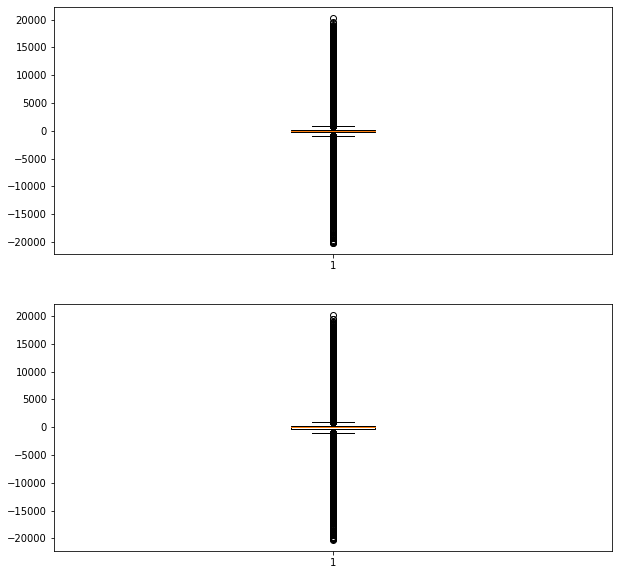

In [20]:
figure, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].boxplot(sample_array_as_dataframe)
axes[1].boxplot(sample_array_as_dataframe_without_zeroes)

plt.show()

The range of the values is enormous (-20000, 20000), so a boxplot doesn't really help.

[]

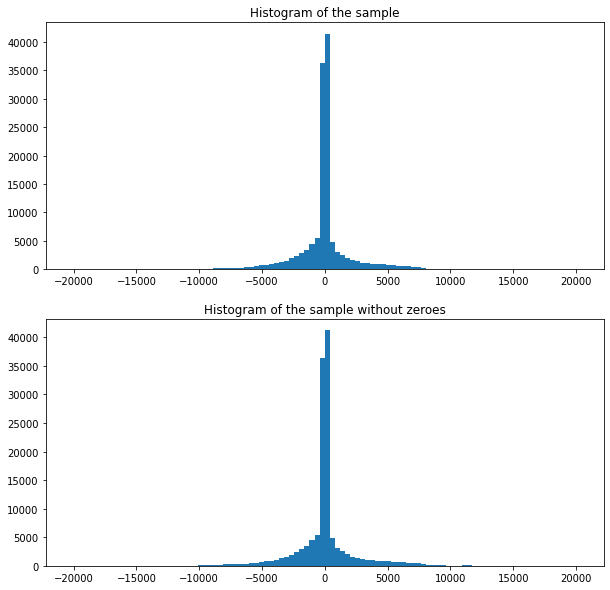

In [19]:
figure, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].set_title("Histogram of the sample")
axes[0].hist(sample_array_as_dataframe, bins=100)

axes[1].set_title("Histogram of the sample without zeroes")
axes[1].hist(sample_array_as_dataframe_without_zeroes, bins=100)
plt.plot()

We notice that there are lots of values centered around zero, which means that there is quite a lot of silence in a sample. In order to visualize the distribution in a clearer way, we can display the distribution of all values within and outside the interquartile range.

In [29]:
first_quartile = np.quantile(sample_array_as_dataframe_without_zeroes, 0.25, axis=0)
third_quartile = np.quantile(sample_array_as_dataframe_without_zeroes, 0.75, axis=0)
sample_array_as_dataframe_within_the_interquartile_range = pd.Series(sample_array_as_dataframe_without_zeroes[(sample_array_as_dataframe_without_zeroes > first_quartile) & (sample_array_as_dataframe_without_zeroes < third_quartile)])
sample_array_as_dataframe_outside_the_interquartile_range = pd.Series(sample_array_as_dataframe_without_zeroes[(sample_array_as_dataframe_without_zeroes < first_quartile) | (sample_array_as_dataframe_without_zeroes > third_quartile)])
sample_array_as_dataframe_within_the_interquartile_range.describe()

count    66761.000000
mean       -14.732209
std        110.177490
min       -291.000000
25%        -96.000000
50%         -5.000000
75%         72.000000
max        190.000000
dtype: float64

In [30]:
sample_array_as_dataframe_outside_the_interquartile_range.describe()

count    66713.000000
mean        15.868017
std       3396.981730
min     -20206.000000
25%      -1643.000000
50%       -293.000000
75%       1385.000000
max      20193.000000
dtype: float64

[]

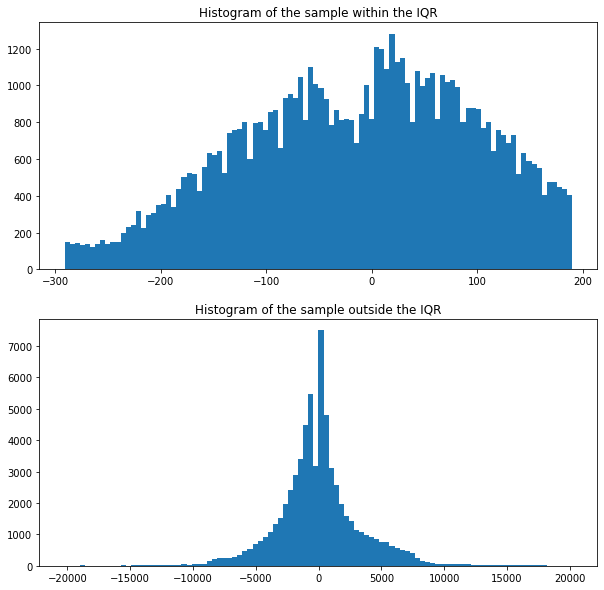

In [33]:
figure, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].set_title("Histogram of the sample within the IQR")
axes[0].hist(sample_array_as_dataframe_within_the_interquartile_range, bins=100)
axes[1].set_title("Histogram of the sample outside the IQR")
axes[1].hist(sample_array_as_dataframe_outside_the_interquartile_range, bins=100)

plt.plot()

From the histogram displaying the distribution of values outside the IQR, we can deduce that most values are located somewhere between -10000 and +10000.

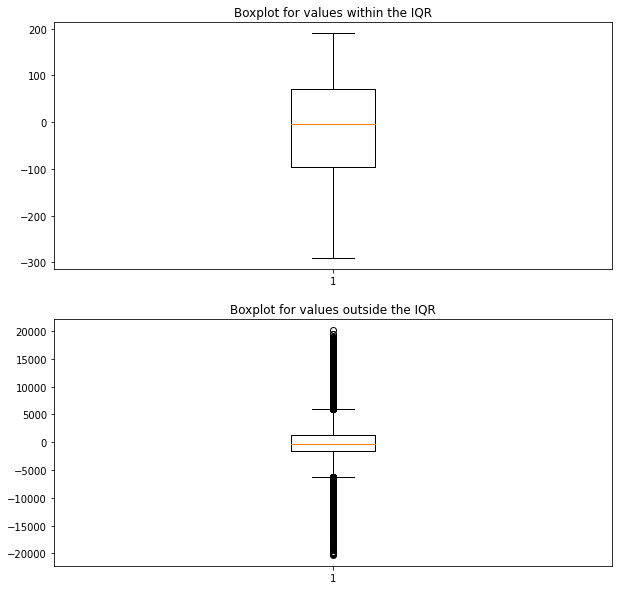

In [35]:
figure, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].set_title("Boxplot for values within the IQR")
axes[0].boxplot(sample_array_as_dataframe_within_the_interquartile_range)
axes[1].set_title("Boxplot for values outside the IQR")
axes[1].boxplot(sample_array_as_dataframe_outside_the_interquartile_range)

plt.show()

## Checking the spectral content and what chunk size would fit for the task

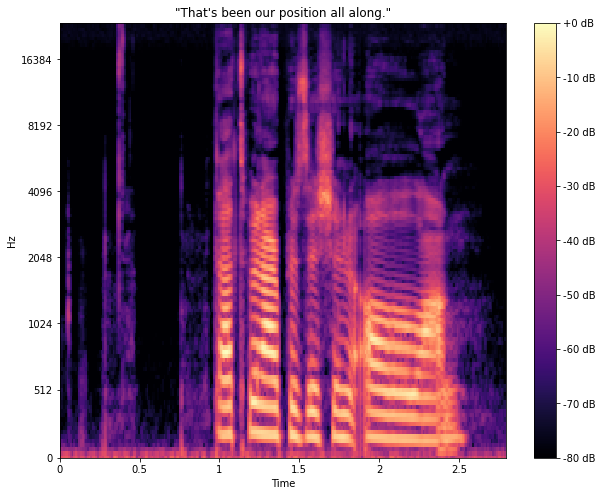

In [44]:
import librosa
import librosa.display

audio_clip_spectrogram = librosa.feature.melspectrogram(sample_array, sr=VCTK_DATASET_SAMPLING_RATE)
decibel_units = librosa.power_to_db(audio_clip_spectrogram, ref=np.max)
figure, axes = plt.subplots(1, 1, figsize=(10,8))

spectrogram_plot = librosa.display.specshow(decibel_units, x_axis='time',
                    y_axis='mel', sr=VCTK_DATASET_SAMPLING_RATE, ax=axes)

figure.colorbar(spectrogram_plot, ax=axes, format='%+2.0f dB')
axes.set_title("{}".format(str(transcript.numpy())[1:]))
plt.show()

We can use IPython.display.Audio(...) to embed the recording in the Jupyter Notebook.

In [67]:
from IPython.display import Audio

full_recording_filename = "exploratory-data-analysis-track-no-{}-high-res.wav".format(chosen_recording)
sf.write("outputs/exploratory-data-analysis/{}".format(full_recording_filename), np.int16(sample_array), VCTK_DATASET_SAMPLING_RATE)

Audio("outputs/exploratory-data-analysis/{}".format(full_recording_filename), rate=VCTK_DATASET_SAMPLING_RATE)

Length of the sample recording

In [48]:
print(len(sample_array))

133781


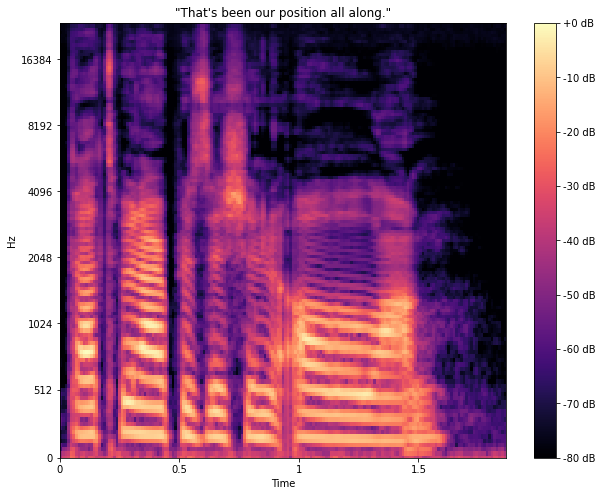

In [68]:
content_after_one_second_filename = "exploratory-data-analysis-track-no-{}-high-res-after-1-sec.wav".format(chosen_recording)
cropped_sample_array = sample_array[len(sample_array) - 2 * len(sample_array) // 3:]
sf.write("outputs/exploratory-data-analysis/{}".format(content_after_one_second_filename), np.int16(cropped_sample_array), VCTK_DATASET_SAMPLING_RATE)

audio_clip_spectrogram = librosa.feature.melspectrogram(cropped_sample_array, sr=VCTK_DATASET_SAMPLING_RATE)
decibel_units = librosa.power_to_db(audio_clip_spectrogram, ref=np.max)
figure, axes = plt.subplots(1, 1, figsize=(10,8))

spectrogram_plot = librosa.display.specshow(decibel_units, x_axis='time',
                                            y_axis='mel', sr=VCTK_DATASET_SAMPLING_RATE, ax=axes)

figure.colorbar(spectrogram_plot, ax=axes, format='%+2.0f dB')
axes.set_title("{}".format(str(transcript.numpy())[1:]))
plt.show()

In [69]:
Audio("outputs/exploratory-data-analysis/{}".format(content_after_one_second_filename), rate=VCTK_DATASET_SAMPLING_RATE)

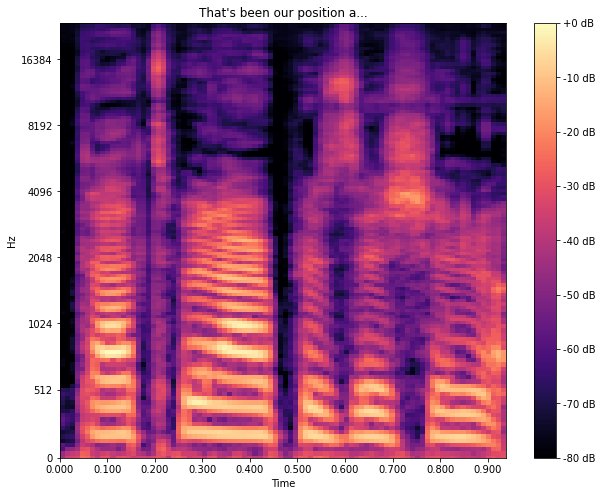

In [70]:
approximately_one_second_of_the_sample = cropped_sample_array[: len(cropped_sample_array) // 2]

first_second_clip_filename = "exploratory-data-analysis-track-no-{}-high-res-first-sec.wav".format(chosen_recording)
sf.write("outputs/exploratory-data-analysis/{}".format(first_second_clip_filename), np.int16(approximately_one_second_of_the_sample), VCTK_DATASET_SAMPLING_RATE)

audio_clip_spectrogram = librosa.feature.melspectrogram(approximately_one_second_of_the_sample, sr=VCTK_DATASET_SAMPLING_RATE)
decibel_units = librosa.power_to_db(audio_clip_spectrogram, ref=np.max)
figure, axes = plt.subplots(1, 1, figsize=(10, 8))

spectrogram_plot = librosa.display.specshow(decibel_units, x_axis='time',
                                            y_axis='mel', sr=VCTK_DATASET_SAMPLING_RATE, ax=axes)

figure.colorbar(spectrogram_plot, ax=axes, format='%+2.0f dB')
axes.set_title("{}".format("That's been our position a..."))
plt.show()

In [71]:
Audio("outputs/exploratory-data-analysis/{}".format(first_second_clip_filename), rate=VCTK_DATASET_SAMPLING_RATE)

In [56]:
print("Number of samples in a clip of approximately 1 second: {}".format(len(approximately_one_second_of_the_sample)))

Number of samples in a clip of approximately 1 second: 44593


We notice that the number of samples in the numpy array of approximately one second is close to 48000, so the sample rate of 48 kHz found on Google is accurate.

For a chunk of 100 milliseconds (a tenth of a second) from a 48 kHz recording, we need $ \frac{48000}{10} = 4800 $ samples.
An interesting idea would be to try multiple chunk sizes, one for chunks of 100 milliseconds, one for chunks of 250 milliseconds, for chunks of 500 milliseconds and one for chunks of 1 second (for which the model would take more time and data to train).
This is how a chunk of 100 milliseconds looks:

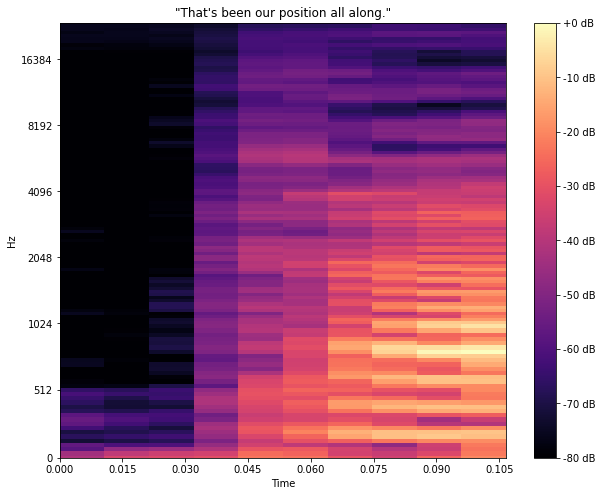

In [72]:
chunk_of_100_ms = approximately_one_second_of_the_sample[:4800]

clip_of_100_milliseconds_filename = "exploratory-data-analysis-track-no-{}-high-res-first-100-ms.wav".format(chosen_recording)
sf.write("outputs/exploratory-data-analysis/{}".format(clip_of_100_milliseconds_filename), np.int16(chunk_of_100_ms), VCTK_DATASET_SAMPLING_RATE)

audio_clip_spectrogram = librosa.feature.melspectrogram(chunk_of_100_ms, sr=VCTK_DATASET_SAMPLING_RATE)
decibel_units = librosa.power_to_db(audio_clip_spectrogram, ref=np.max)
figure, axes = plt.subplots(1, 1, figsize=(10,8))

spectrogram_plot = librosa.display.specshow(decibel_units, x_axis='time',
                                            y_axis='mel', sr=VCTK_DATASET_SAMPLING_RATE, ax=axes)

figure.colorbar(spectrogram_plot, ax=axes, format='%+2.0f dB')
axes.set_title("{}".format(str(transcript.numpy())[1:]))
plt.show()

Obviously, the spectrogram doesn't really help in this case, because the audio clip is extremely short.
Here is how it sounds:

In [73]:
Audio("outputs/exploratory-data-analysis/{}".format(clip_of_100_milliseconds_filename), rate=VCTK_DATASET_SAMPLING_RATE)

Indeed, it is a very short sound, but moving a sliding window all over a low-resolution recording to run the model on a small 100-milliseconds chunk in the execution script might work properly (remains to be seen later on after training)

We can try downsampling the clip and perhaps also interpolating it afterwards to compare the spectrograms.

In [74]:
downsampled_array = np.array(sample_array[0::RESAMPLING_FACTOR])
downsampled_recording_filename = "exploratory-data-analysis-track-no-{}-downsampled-without-interpolation.wav".format(chosen_recording)
sf.write("outputs/exploratory-data-analysis/{}".format(downsampled_recording_filename), np.int16(downsampled_array), VCTK_DATASET_SAMPLING_RATE)
Audio("outputs/exploratory-data-analysis/{}".format(downsampled_recording_filename), rate=VCTK_DATASET_SAMPLING_RATE)

Due to the recording getting downsampled by a factor of 4, the pitch of the voice in the WAV file sounds hilariously high and cartoonish. We have to adjust the sample rate properly.

In [80]:
sf.write("outputs/exploratory-data-analysis/{}".format(downsampled_recording_filename), np.int16(downsampled_array), DOWNSAMPLED_RATE)
Audio("outputs/exploratory-data-analysis/{}".format(downsampled_recording_filename), rate=DOWNSAMPLED_RATE)

Now we can compare the spectrograms of the high-res and low-res clips:

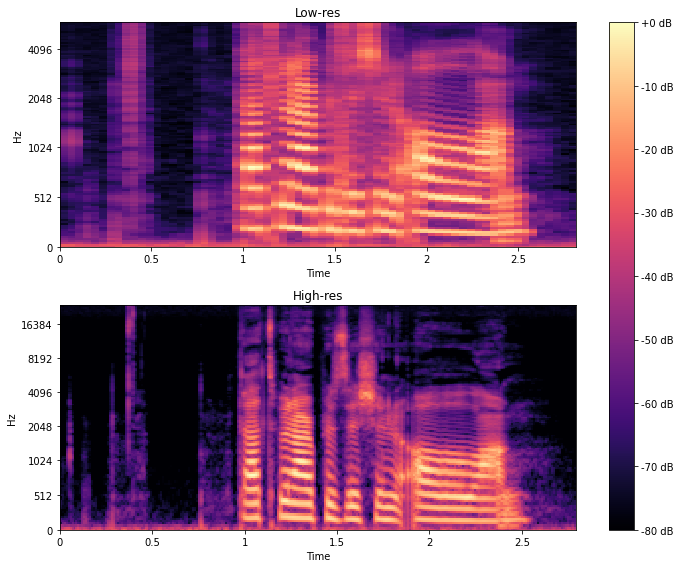

In [83]:
high_res_audio_clip_spectrogram = librosa.feature.melspectrogram(sample_array, sr=VCTK_DATASET_SAMPLING_RATE)
high_res_decibel_units = librosa.power_to_db(high_res_audio_clip_spectrogram, ref=np.max)
low_res_audio_clip_spectrogram = librosa.feature.melspectrogram(downsampled_array, sr=DOWNSAMPLED_RATE)
low_res_decibel_units = librosa.power_to_db(low_res_audio_clip_spectrogram, ref=np.max)
figure, axes = plt.subplots(2, 1, figsize=(10, 8))

axes[0].set_title("Low-res")
low_res_spectrogram_plot = librosa.display.specshow(low_res_decibel_units, x_axis='time',
                                                     y_axis='mel', sr=DOWNSAMPLED_RATE, ax=axes[0])

axes[1].set_title("High-res")
high_res_spectrogram_plot = librosa.display.specshow(high_res_decibel_units, x_axis='time',
                            y_axis='mel', sr=VCTK_DATASET_SAMPLING_RATE, ax=axes[1])

figure.tight_layout()
figure.colorbar(low_res_spectrogram_plot, ax=[axes[0], axes[1]], format='%+2.0f dB')
plt.show()

Now we can also interpolate the downsampled signal and compare all 3 versions.

In [86]:
downsampled_and_interpolated_array = DatasetGenerator.upsample(downsampled_array, RESAMPLING_FACTOR)
downsampled_recording_with_interpolation_filename = "exploratory-data-analysis-track-no-{}-downsampled-with-interpolation.wav".format(chosen_recording)
sf.write("outputs/exploratory-data-analysis/{}".format(downsampled_recording_with_interpolation_filename), np.int16(downsampled_and_interpolated_array), VCTK_DATASET_SAMPLING_RATE)
Audio("outputs/exploratory-data-analysis/{}".format(downsampled_recording_with_interpolation_filename), rate=VCTK_DATASET_SAMPLING_RATE)

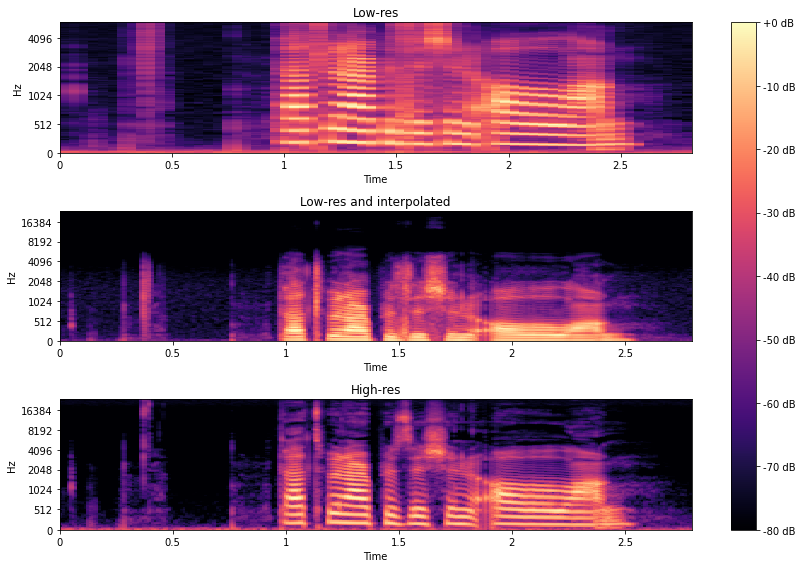

In [88]:
high_res_audio_clip_spectrogram = librosa.feature.melspectrogram(sample_array, sr=VCTK_DATASET_SAMPLING_RATE)
high_res_decibel_units = librosa.power_to_db(high_res_audio_clip_spectrogram, ref=np.max)
low_res_audio_clip_spectrogram = librosa.feature.melspectrogram(downsampled_array, sr=DOWNSAMPLED_RATE)
low_res_decibel_units = librosa.power_to_db(low_res_audio_clip_spectrogram, ref=np.max)
low_res_with_interpolation_audio_clip_spectrogram = librosa.feature.melspectrogram(downsampled_and_interpolated_array, sr=DOWNSAMPLED_RATE)
low_res_with_interpolation_decibel_units = librosa.power_to_db(low_res_with_interpolation_audio_clip_spectrogram, ref=np.max)
figure, axes = plt.subplots(3, 1, figsize=(12, 8))

axes[0].set_title("Low-res")
low_res_spectrogram_plot = librosa.display.specshow(low_res_decibel_units, x_axis='time',
                                                    y_axis='mel', sr=DOWNSAMPLED_RATE, ax=axes[0])

axes[1].set_title("Low-res and interpolated")
low_res_and_interpolated_spectrogram_plot = librosa.display.specshow(low_res_with_interpolation_decibel_units, x_axis='time',
                                                    y_axis='mel', sr=VCTK_DATASET_SAMPLING_RATE, ax=axes[1])

axes[2].set_title("High-res")
high_res_spectrogram_plot = librosa.display.specshow(high_res_decibel_units, x_axis='time',
                                                     y_axis='mel', sr=VCTK_DATASET_SAMPLING_RATE, ax=axes[2])

figure.tight_layout()
figure.colorbar(low_res_spectrogram_plot, ax=[axes[0], axes[1], axes[2]], format='%+2.0f dB')
plt.show()

One thing to notice is that interpolating the downsampled signal recovers a few of the high frequency components, but not enough of them.

Downsampling the signal simply cuts off most of the frequency components above 4096 Hz.

Obviously, the high-resolution recording has harmonics that are much more fine-grained and well-defined when compared to the low-res-and-interpolation version of the recording.